## ライブラリのImport

In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util import get_rect
from dset import getImageInfoList

## データの読み込み

In [2]:
# 画像データ読み込み
X_train = np.load('/mnt/c/Users/user/MyData/SonyDice/X_train.npy')
X_train = np.reshape(X_train, [200000, 20, 20])
X_train.shape

(200000, 20, 20)

In [3]:
X_test = np.load('/mnt/c/Users/user/MyData/SonyDice/X_test.npy')
X_test = np.reshape(X_test, [10000, 20, 20])
X_test.shape

(10000, 20, 20)

In [4]:
# ラベルデータ読み込み
y_train = np.load('/mnt/c/Users/user/MyData/SonyDice/y_train.npy')
y_train.shape

(200000,)

## 可視化と矩形検出

In [5]:
n = 50

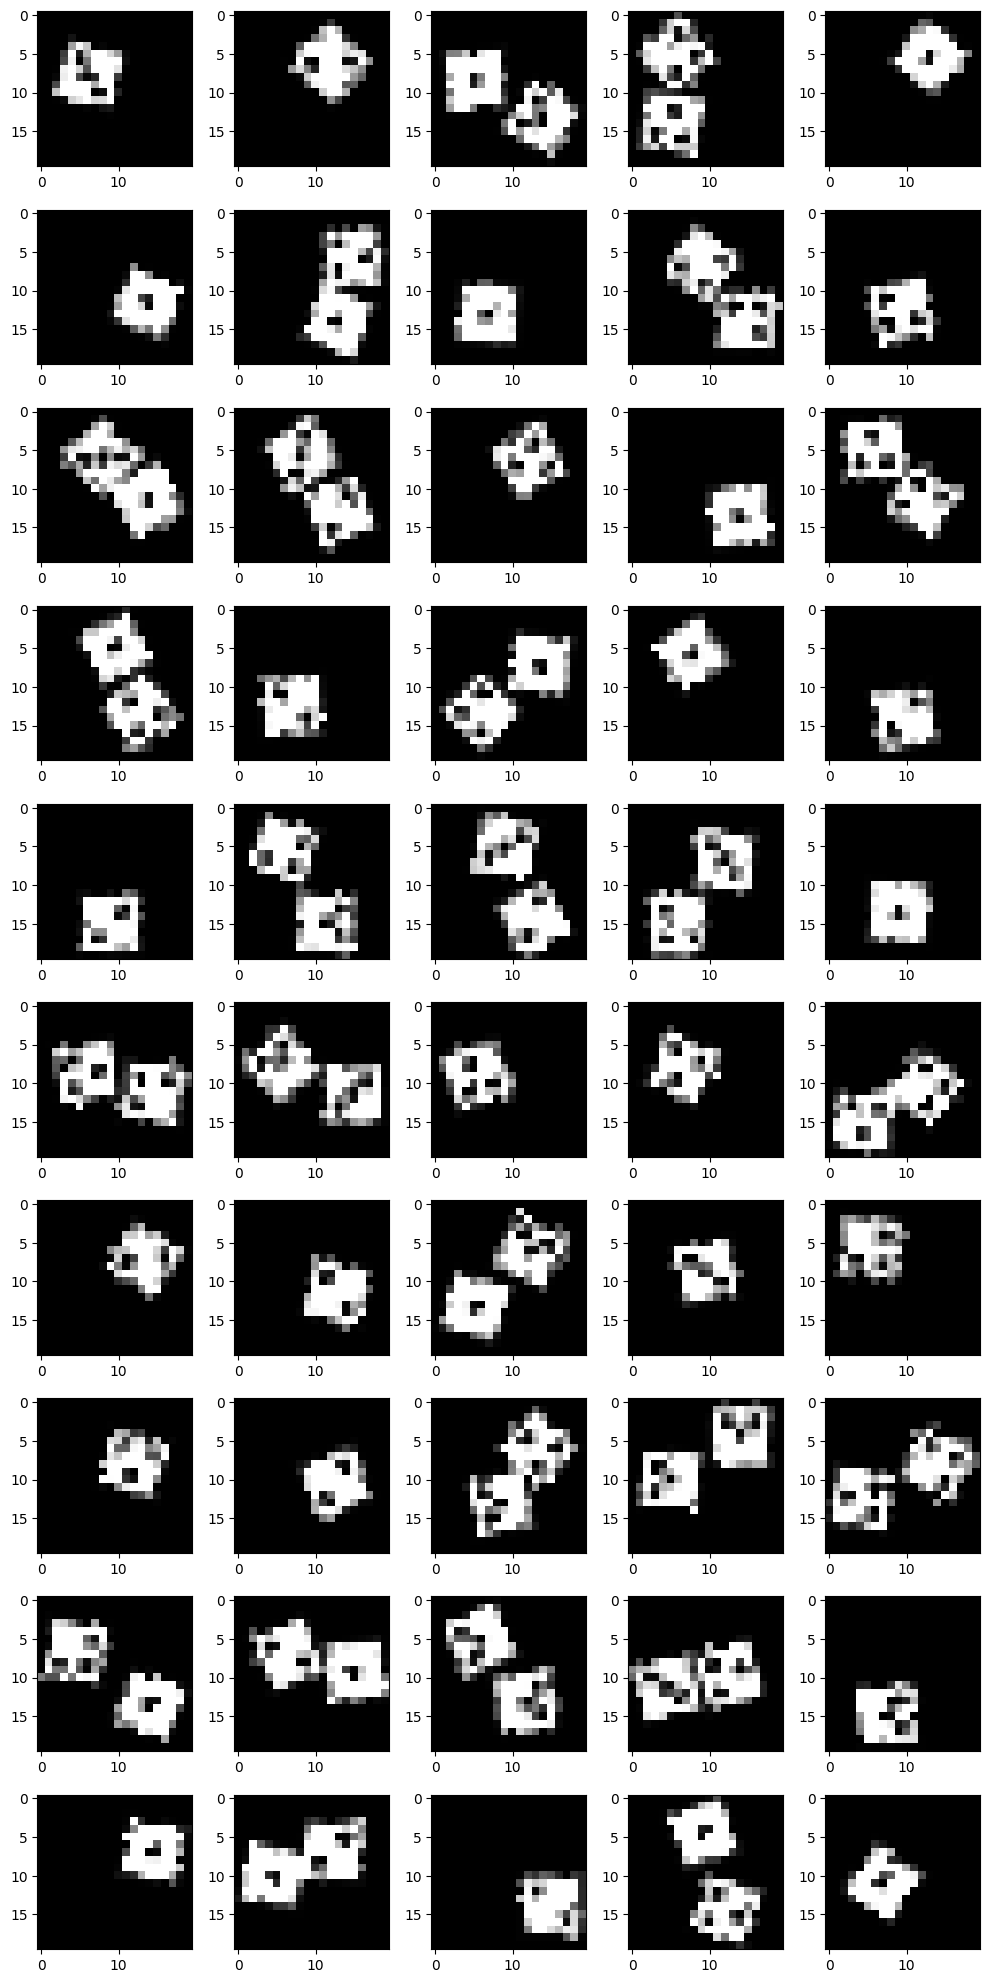

In [6]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
for cnt, i in enumerate(range(n)):
    ax = fig.add_subplot(n//5, 5, cnt+1)
    plt.imshow(X_train[i, :], cmap='gray')
    plt.tight_layout()

## Resizeと二値化

In [7]:
imgs = X_train[:n, :]

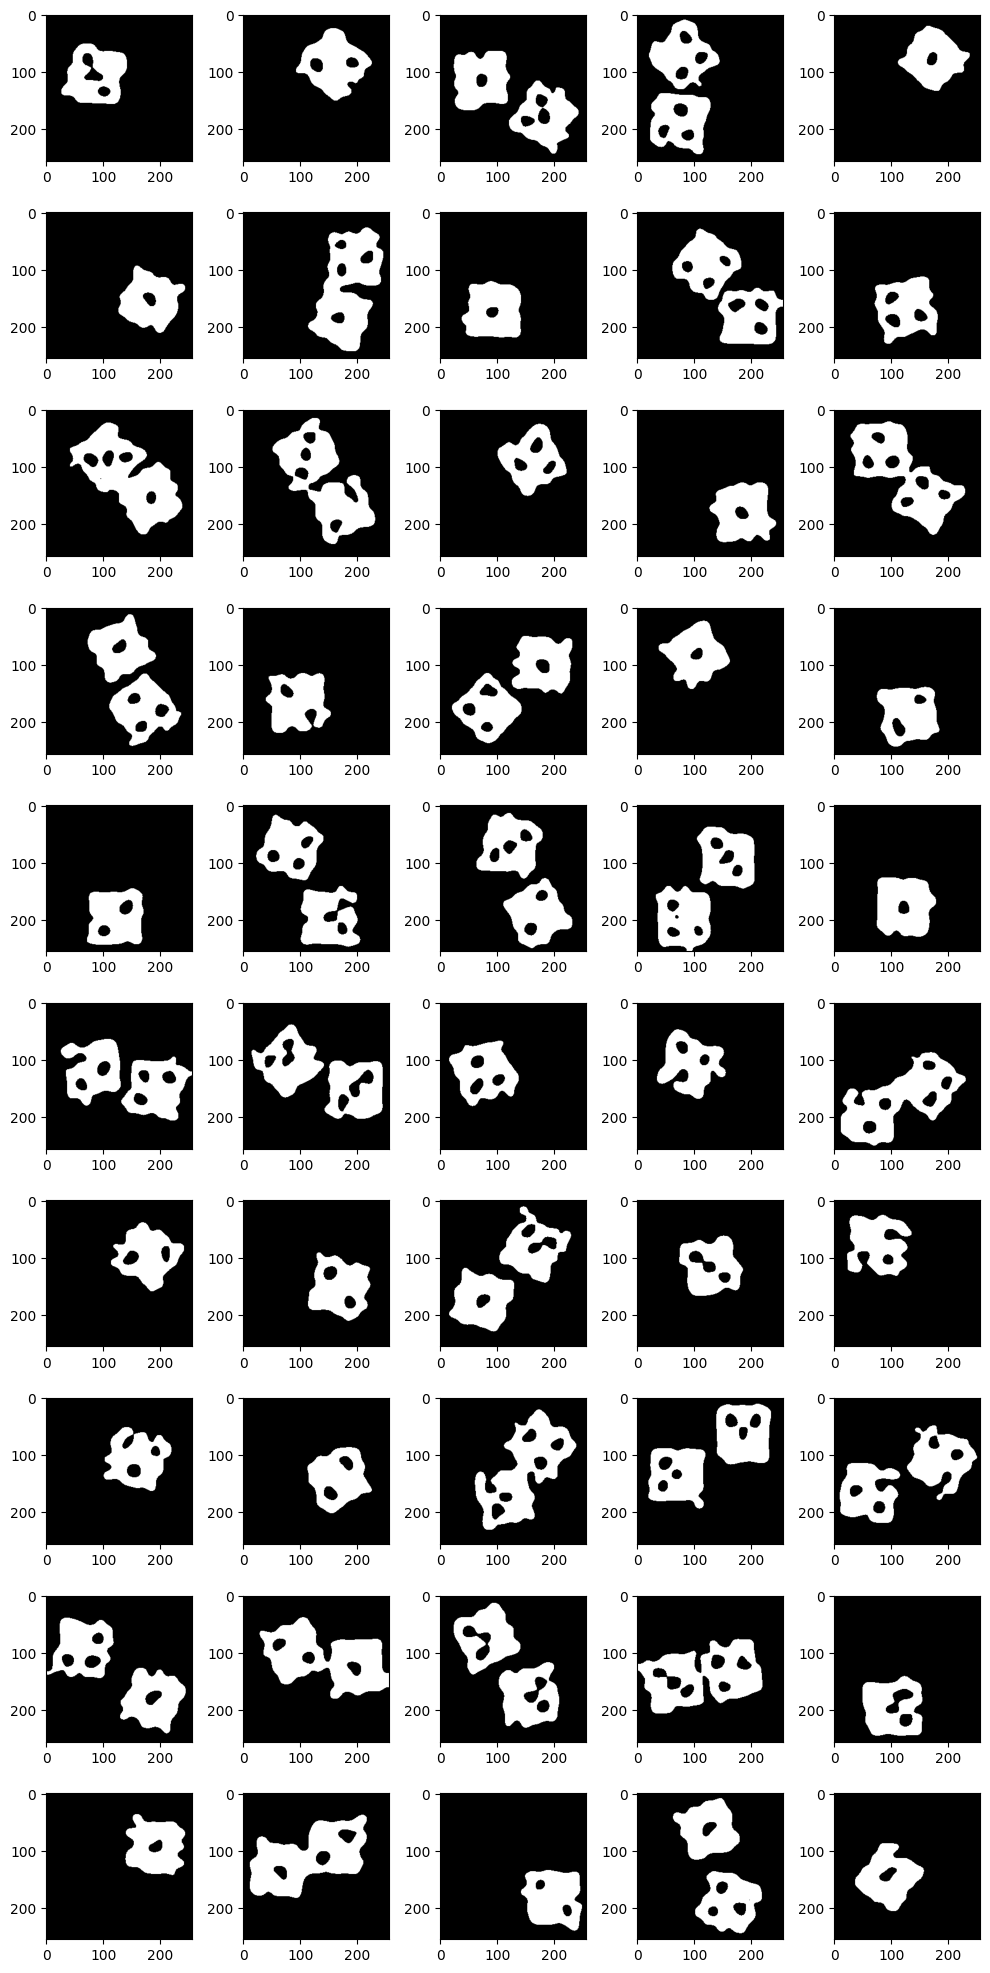

In [8]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
imgs_bi = np.ones((n, 256, 256), dtype='uint8')
for i, img in enumerate(imgs):
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    imgs_bi[i, :] = img

    # show image
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

## 輪郭と矩形検知

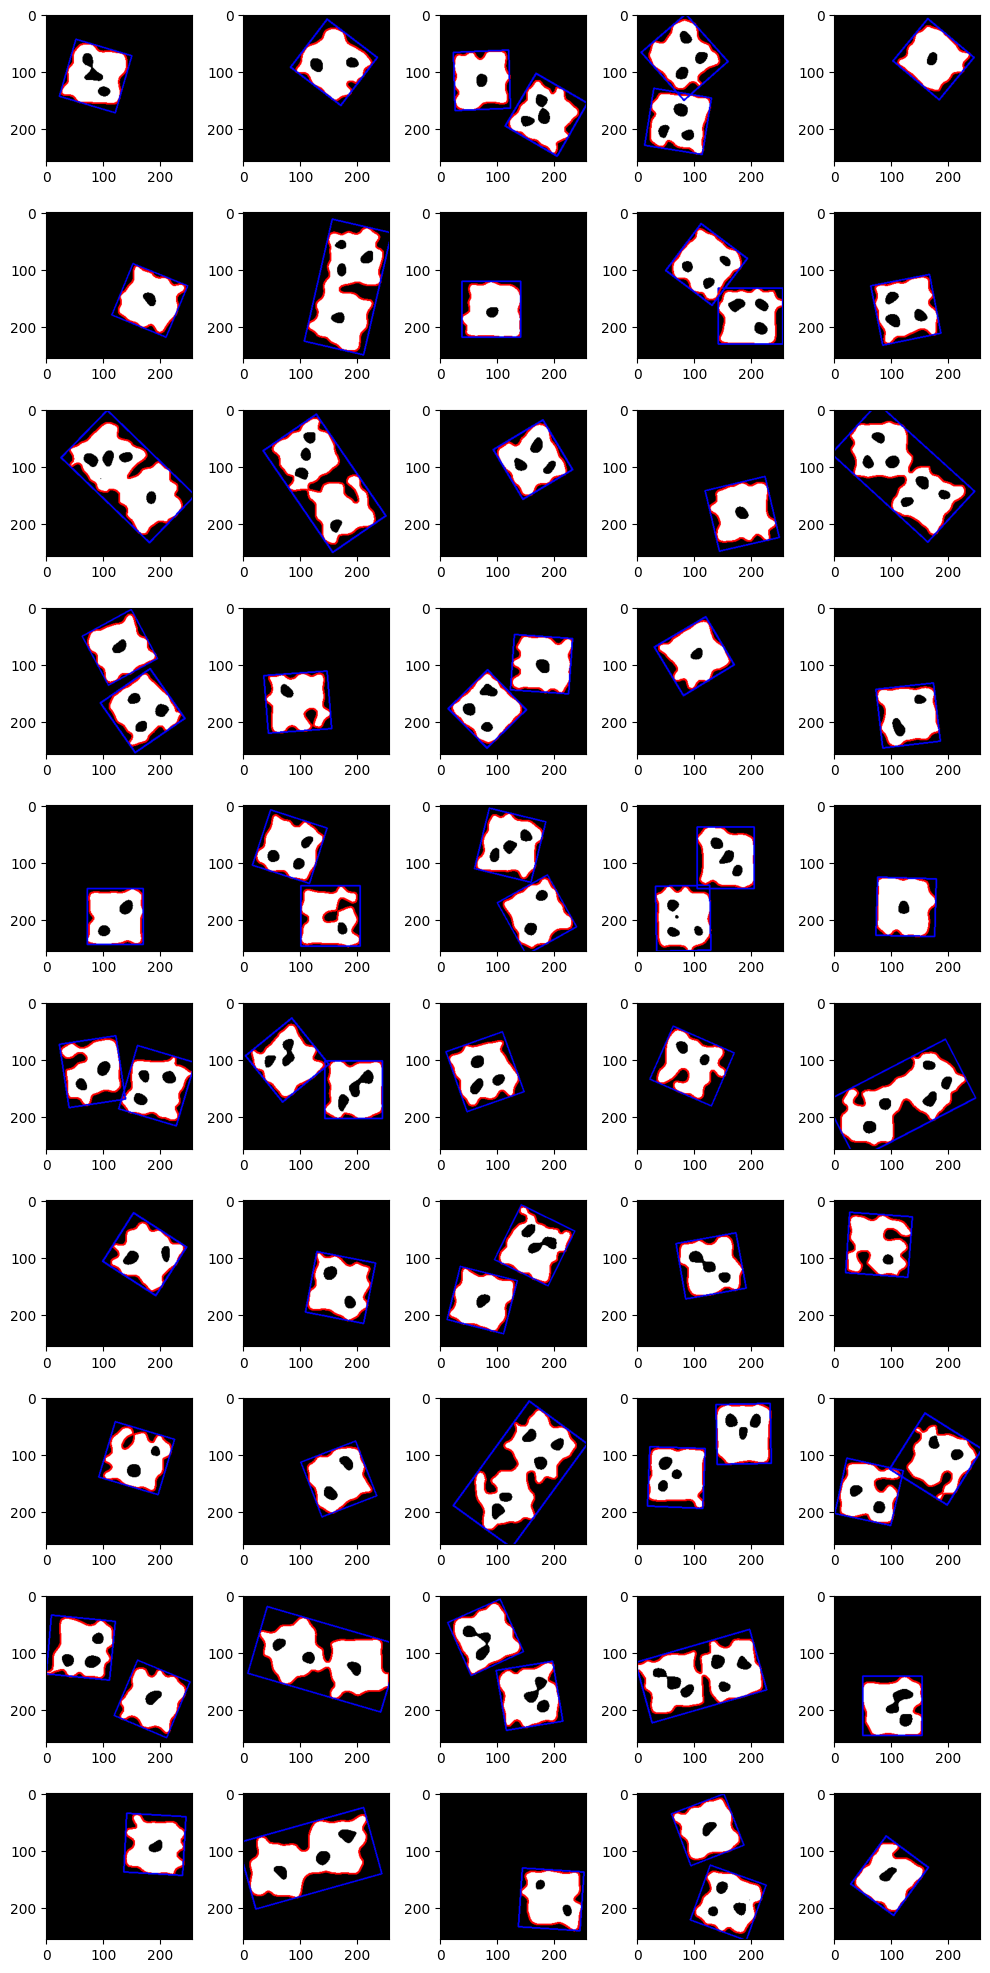

In [9]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))

for i in range(n):
    contours, hierarchy = cv2.findContours(image=imgs_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_bi[i, :], cv2.COLOR_GRAY2BGR)

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img_disp, cmap='gray')
    plt.tight_layout()

In [10]:
rect_centers = []
rect_sizes = []

for i in range(X_train.shape[0]):
    img = X_train[i, :]
    
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    rect_center, rect_size, rect_angle = get_rect(img)

    rect_centers += rect_center 
    rect_sizes += rect_size

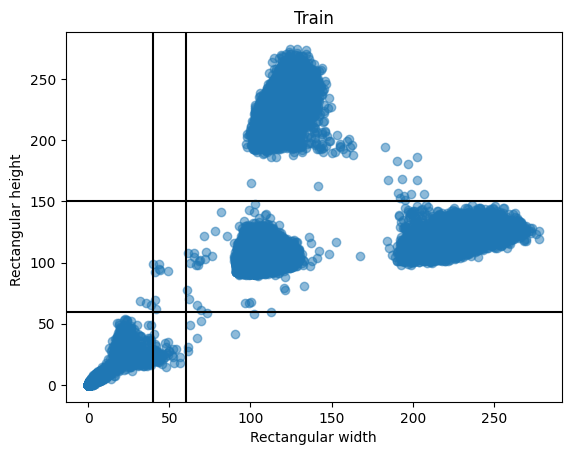

In [11]:
# 矩形形状の分布の確認
width = [rect_size[0] for rect_size in rect_sizes]
height = [rect_size[1] for rect_size in rect_sizes]

fig, ax = plt.subplots()
ax.axhline(y=60, color='k')
ax.axhline(y=150, color='k')
ax.axvline(x=40, color='k')
ax.axvline(x=60, color='k')
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Rectangular width')
plt.ylabel('Rectangular height ')
plt.title('Train')
plt.show()

### 検証データ

In [12]:
rect_centers_test = []
rect_sizes_test = []

for i in range(X_test.shape[0]):
    img = X_test[i, :]
    
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 otsu
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    rect_center_test, rect_size_test, rect_angle = get_rect(img)

    rect_centers_test += rect_center_test 
    rect_sizes_test += rect_size_test

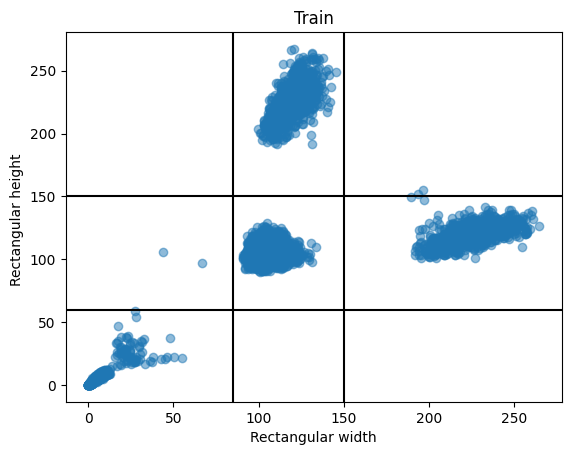

In [13]:
# 矩形形状の分布の確認
width = [rect_size[0] for rect_size in rect_sizes_test]
height = [rect_size[1] for rect_size in rect_sizes_test]

fig, ax = plt.subplots()
ax.axhline(y=60, color='k')
ax.axhline(y=150, color='k')
ax.axvline(x=85, color='k')
ax.axvline(x=150, color='k')
plt.scatter(width, height, alpha=0.5)
plt.xlabel('Rectangular width')
plt.ylabel('Rectangular height ')
plt.title('Train')
plt.show()

### 小さい長細い要素を持つデータを調べる
2値化の時点で完全に割れてしまい小さい片割れができた矩形領域が存在すると思われる

In [14]:
# 長細い矩形を持つ画像のindex
idx_list = []

for i in range(X_train.shape[0]):

    img = X_train[i, :]
    
    # resize and binarization 
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    _, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    rect_center, rect_size, rect_angle = get_rect(img)
    # サイコロのrect情報を格納するリスト
    dice_rect = []
    for j, size_tmp in enumerate(rect_size):
        # if ((size_tmp[0] < 85) and (60 <= size_tmp[1] <= 150)) or ((size_tmp[1] < 85) and (60 <= size_tmp[0] <= 150)):
        if (size_tmp[1] < 60) and (40 <= size_tmp[0] <= 60):
            idx_list.append(i)

print(len(idx_list))

68


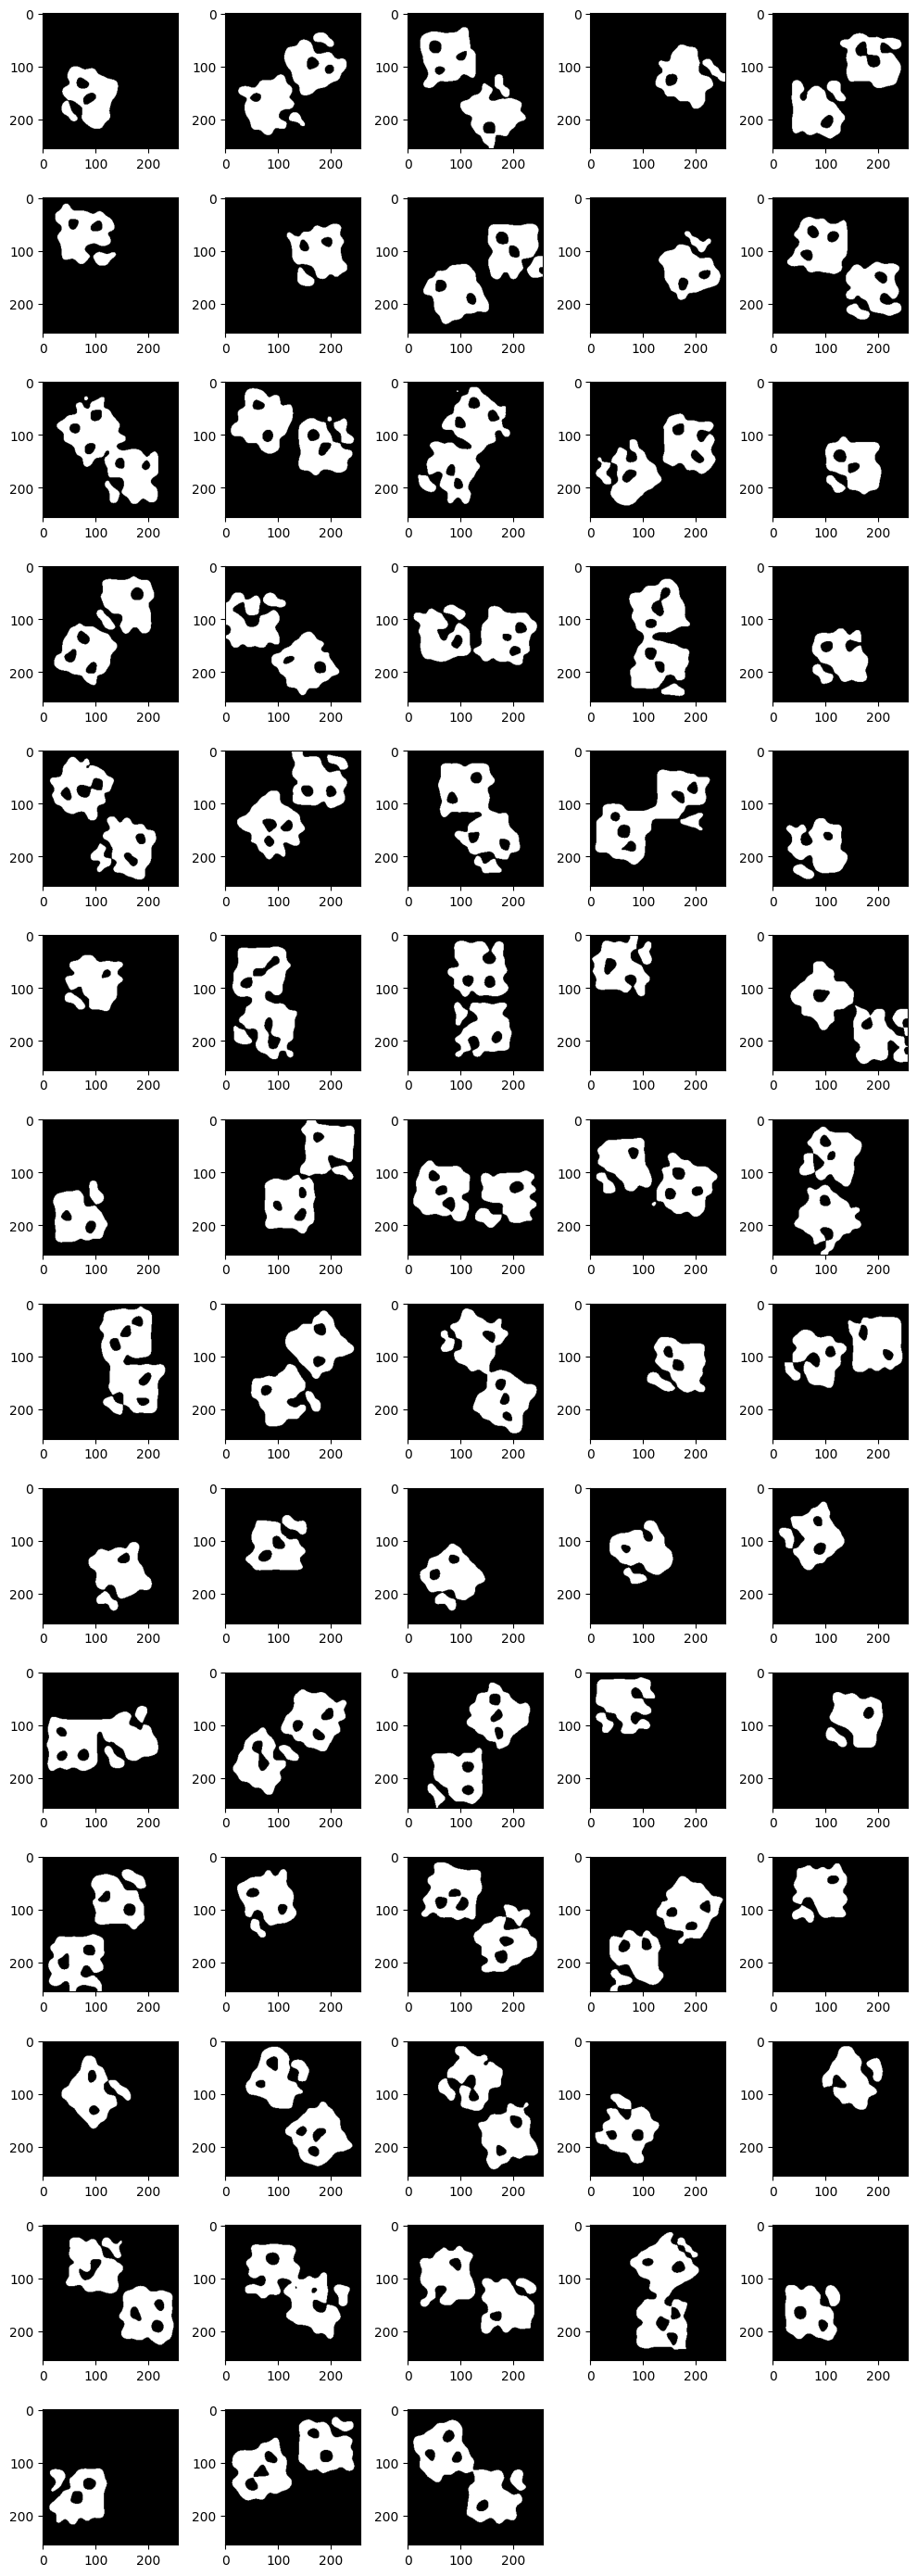

In [15]:
img_num = len(idx_list)

fig = plt.figure(figsize=(10, 10*((img_num//5+1)/5)))
imgs_unusual_bi = np.ones((img_num, 256, 256), dtype='uint8')
for cnt, i in enumerate(idx_list):
    img = X_train[i, :]
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    imgs_unusual_bi[cnt, :] = img

    # show image
    ax = fig.add_subplot((img_num//5) + 1, 5, cnt+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

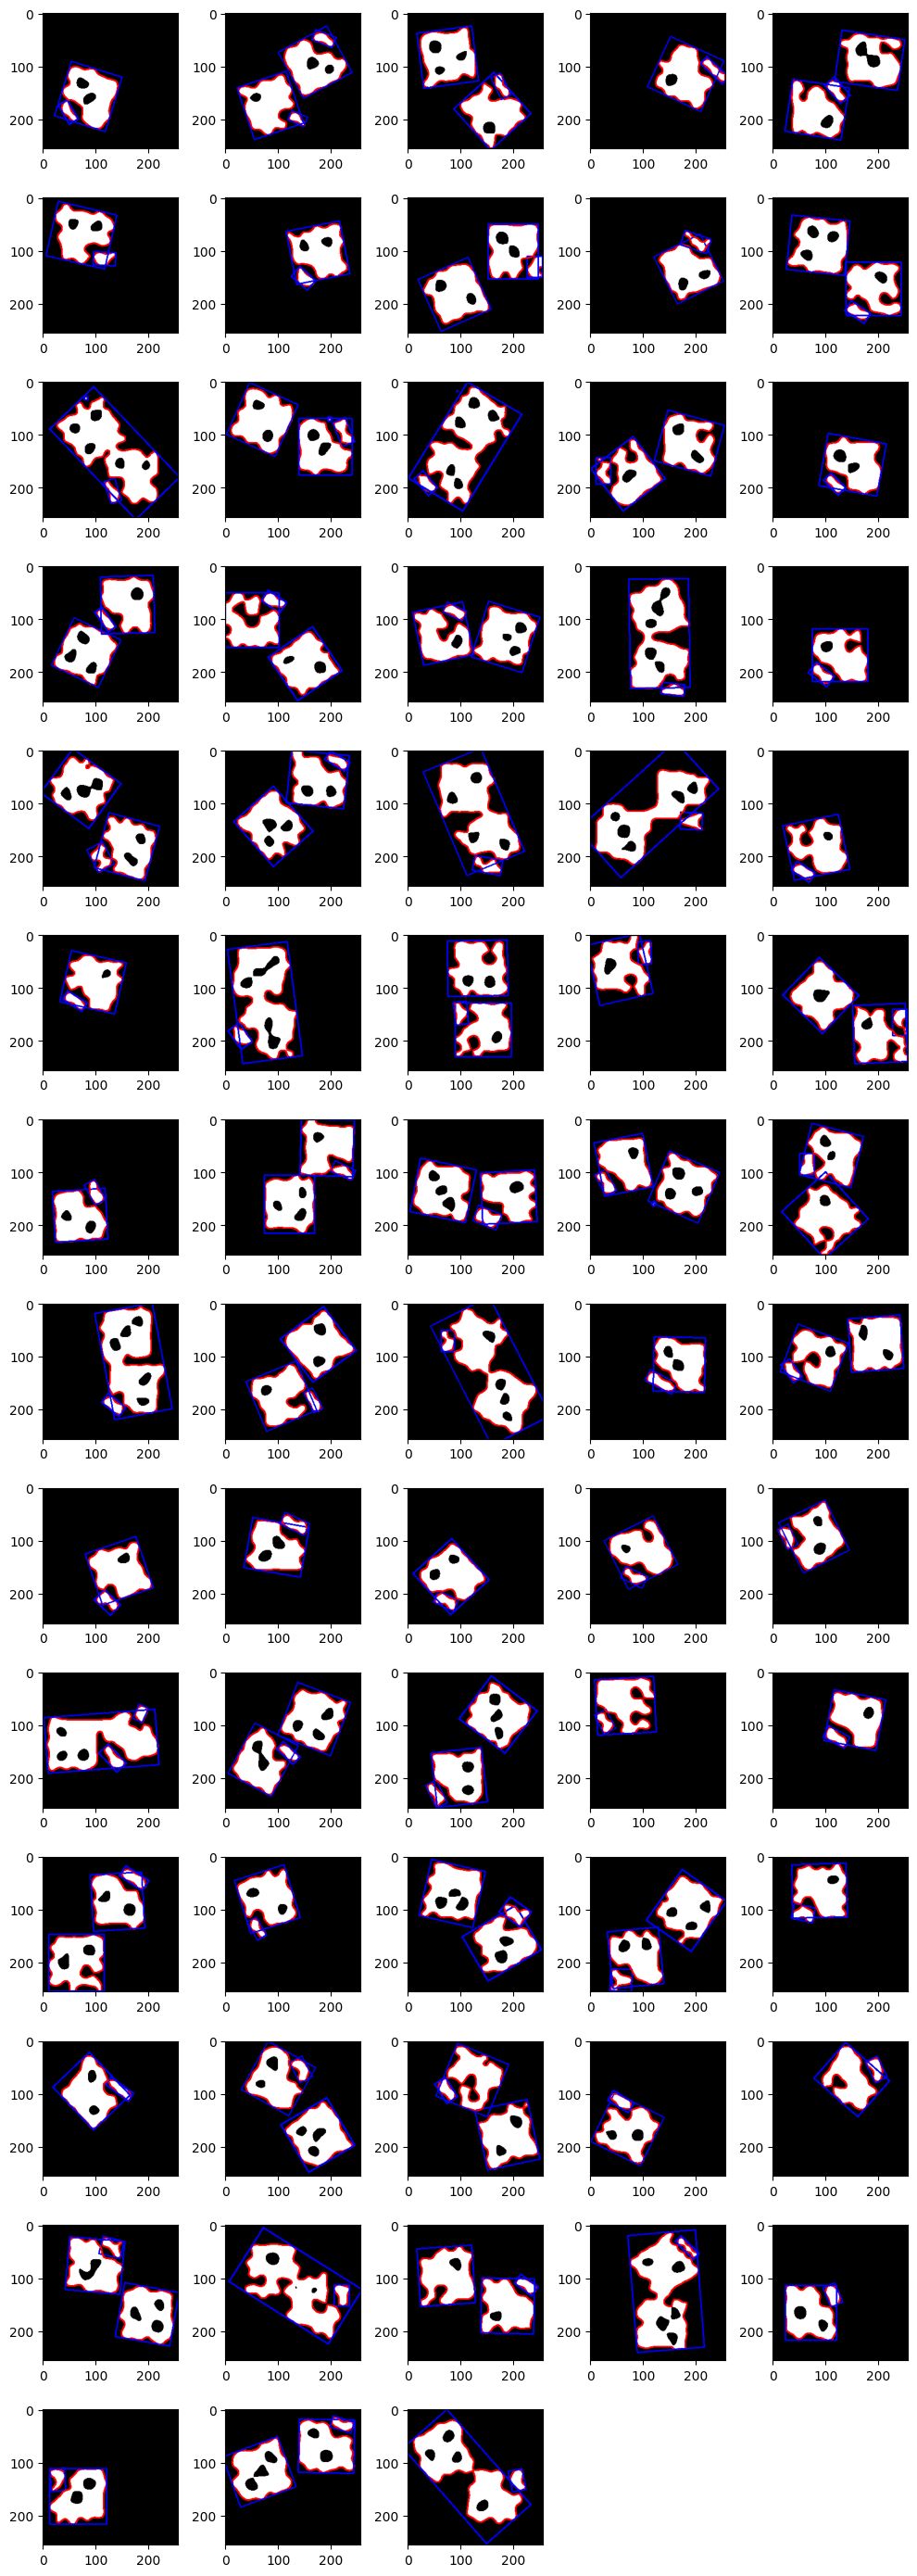

In [16]:
fig = plt.figure(figsize=(10, 10*((img_num//5+1)/5)))

for cnt, i in enumerate(range(len(idx_list))):
    contours, hierarchy = cv2.findContours(image=imgs_unusual_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_unusual_bi[i, :], cv2.COLOR_GRAY2BGR)

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(img_num//5+1, 5, cnt+1)
    plt.imshow(img_disp, cmap='gray')
    plt.tight_layout()

## 学習データの前処理・作成
一つだけサイコロが存在する画像からサイコロの矩形領域を切り出して目の数を学習する

In [17]:
imgs, labels, labels_unexp, labels_undetect = getImageInfoList()

In [18]:
print(f'サイコロを一つしか持たない画像の数: {len(imgs)}')
print(f'ラベルの数: {len(labels)}')

サイコロを一つしか持たない画像の数: 99885
ラベルの数: 99885


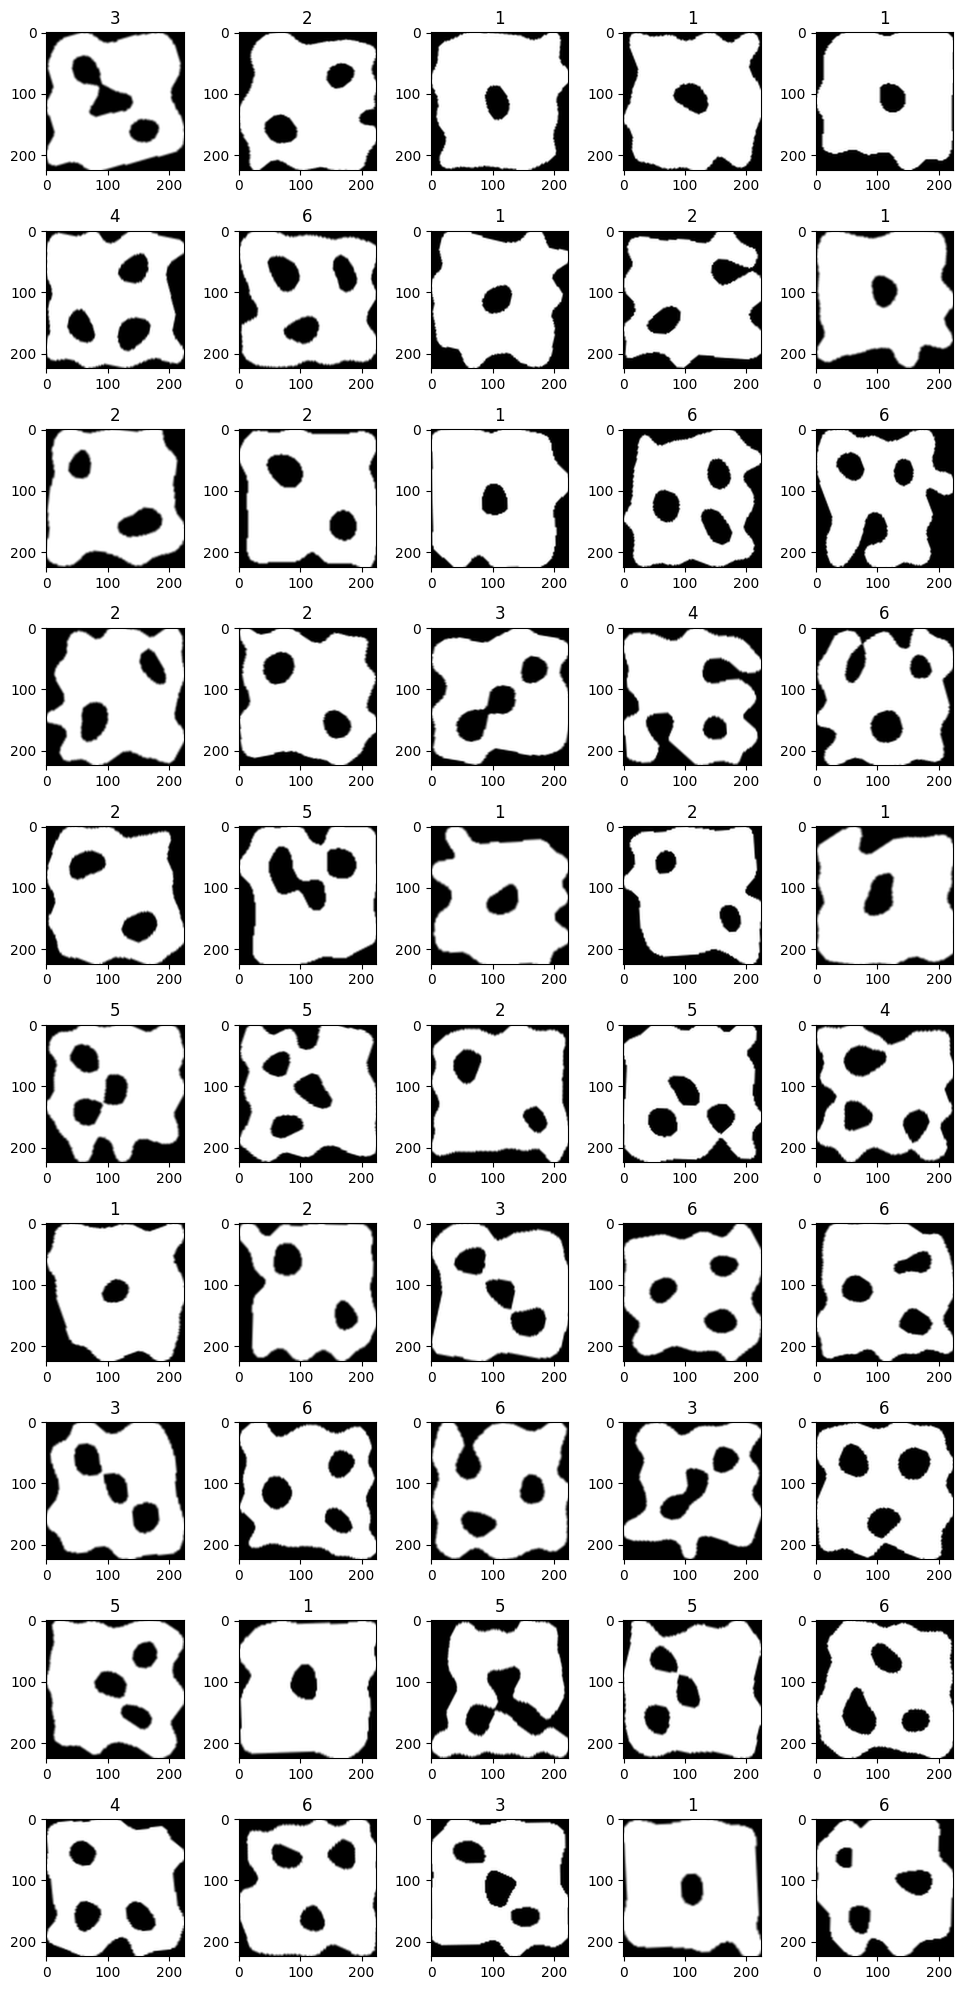

In [19]:
# 可視化
fig = plt.figure(figsize=(10, 10*((n//5)/5)))
for i in range(n):
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(labels[i])
    plt.tight_layout()

### 想定通りにならなかったものを可視化
本来ならサイコロの数は一つなのでラベルは1-6のはずが6を超えてしまった対象

In [20]:
print('想定通りにならなかった画像のインデックス: {}'.format(labels_unexp))

想定通りにならなかった画像のインデックス: [5624, 11239, 31095, 60173, 64111, 79621, 90416, 110545, 155519]


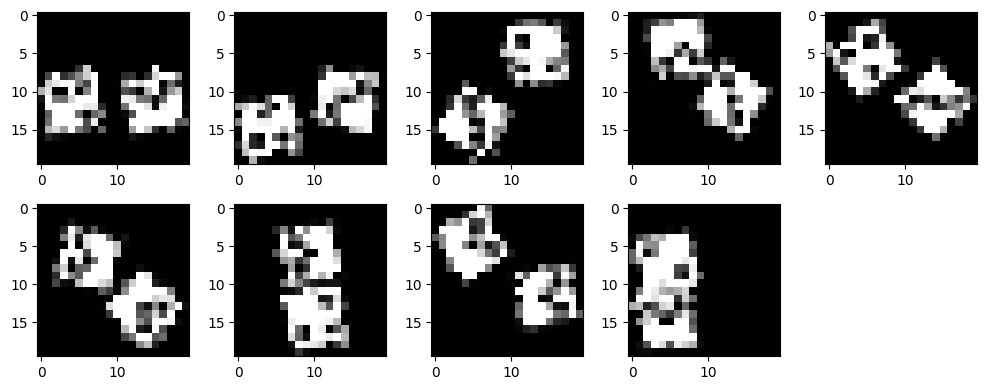

In [21]:
fig = plt.figure(figsize=(10, 10*((10//5)/5)))
for cnt, i in enumerate(labels_unexp):
    ax = fig.add_subplot(10//5, 5, cnt+1)
    plt.imshow(X_train[i, :], cmap='gray')
    plt.tight_layout()

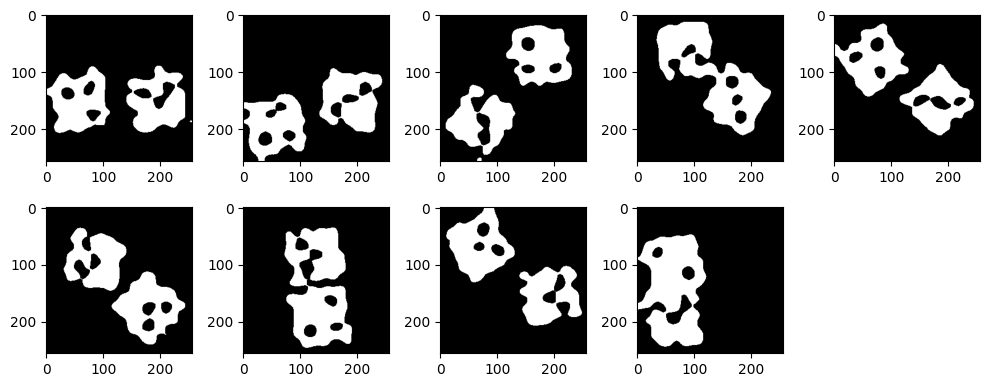

In [35]:
fig = plt.figure(figsize=(10, 10*((10//5)/5)))
imgs_bi = np.ones((len(labels_unexp), 256, 256), dtype='uint8')
for i, idx in enumerate(labels_unexp):
    img = X_train[idx, :]
    # resize ランチョス
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # 2値化 大津
    thresh, img = cv2.threshold(img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # # closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

    imgs_bi[i, :] = img

    # show image
    ax = fig.add_subplot(10//5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()

In [23]:
a = []
len(a)

0

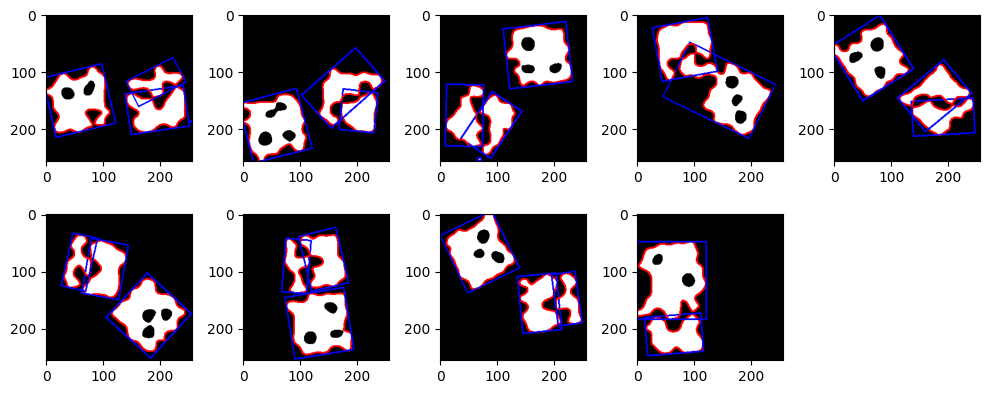

In [24]:
fig = plt.figure(figsize=(10, 10*((n//5)/5)))

for i in range(9):
    contours, hierarchy = cv2.findContours(image=imgs_bi[i, :], # lanczosを使う
                                           mode=cv2.RETR_EXTERNAL, # 一番外側の輪郭のみ
                                           method=cv2.CHAIN_APPROX_SIMPLE) # 輪郭座標の詳細なし

    # 表示用にカラーデータに変換する
    img_disp = cv2.cvtColor(imgs_bi[i, :], cv2.COLOR_GRAY2BGR)

    # 輪郭の描写
    for j, contour in enumerate(contours):
        # 輪郭を描画
        cv2.drawContours(img_disp, contours, j, (255, 0, 0), 2)

        # 傾いた外接する矩形領域
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_disp, [box], 0, (0,0,255), 2)

    # 画像の表示
    ax = fig.add_subplot(n//5, 5, i+1)
    plt.imshow(img_disp, cmap='gray')
    plt.tight_layout()

### サイコロは一つだけど、二つに分かれていて検出できなかったもの

In [28]:
print('サイコロは一つだけど、二つに分かれていて検出できなかったインデックス: {}'.format(len(labels_undetect)))

サイコロは一つだけど、二つに分かれていて検出できなかったインデックス: 39214
